In [331]:
import pandas as pd
import numpy as np

emotions = ['Anxiety', 'Sad', 'Happiness', 'Love']
count_pts = {}
for movie in ['Sintel', 'TearsOfSteel', 'Superhero', 'TheSecretNumber']:
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']

    threshold = 1
    count_pts[movie] = {}
    for emotion in emotions:
        number_points = len(data[data[emotion] > threshold])
        count_pts[movie][emotion] = number_points
    
    count_pts[movie]['All movie'] = len(data)

print(count_pts)


117
117
71
0
82
0
39
24
101
288
56
222
69
0
0
0
{'Sintel': {'Anxiety': 117, 'Sad': 117, 'Happiness': 71, 'Love': 0, 'All movie': 555}, 'TearsOfSteel': {'Anxiety': 82, 'Sad': 0, 'Happiness': 39, 'Love': 24, 'All movie': 452}, 'Superhero': {'Anxiety': 101, 'Sad': 288, 'Happiness': 56, 'Love': 222, 'All movie': 791}, 'TheSecretNumber': {'Anxiety': 69, 'Sad': 0, 'Happiness': 0, 'Love': 0, 'All movie': 603}}


In [254]:
all_emo_data = pd.DataFrame()

for emotion in emotions:
    data_emotion = pd.DataFrame()
    for region in ['ALL', 'VIS', 'SM', 'DMN', 'DA', 'VA', 'FP']:
        data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLS_csv/PLSpeaks_{emotion}_{region}_results.csv')

        # number of movies
        n_movies = data.Movie.unique()

        # boostrap round
        a = np.repeat(np.arange(1,11), 12)
        for i in range(n_movies.shape[0]-1):
            a = np.concatenate((a, np.repeat(np.arange(1,11), 12)), axis = 0)
        data['bootstrap_round'] = a
        
        data_emotion = pd.concat([data_emotion, data], axis=0)
        data_emotion['emotion'] = emotion

    all_emo_data = pd.concat([all_emo_data, data_emotion], axis=0)
    
all_emo_data.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks.csv')

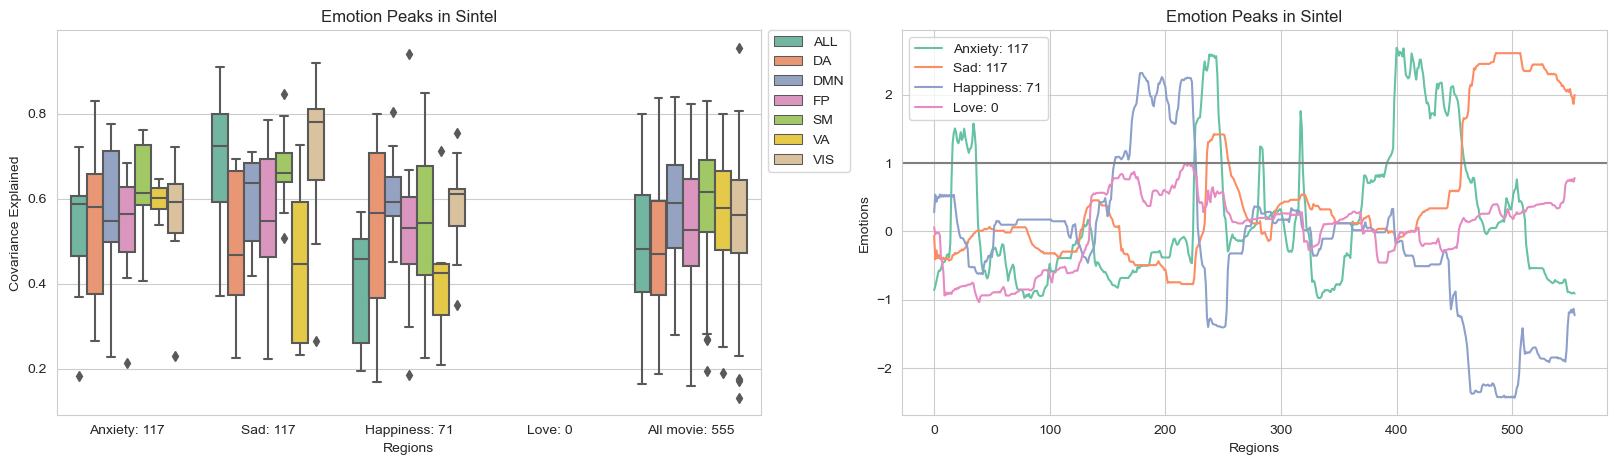

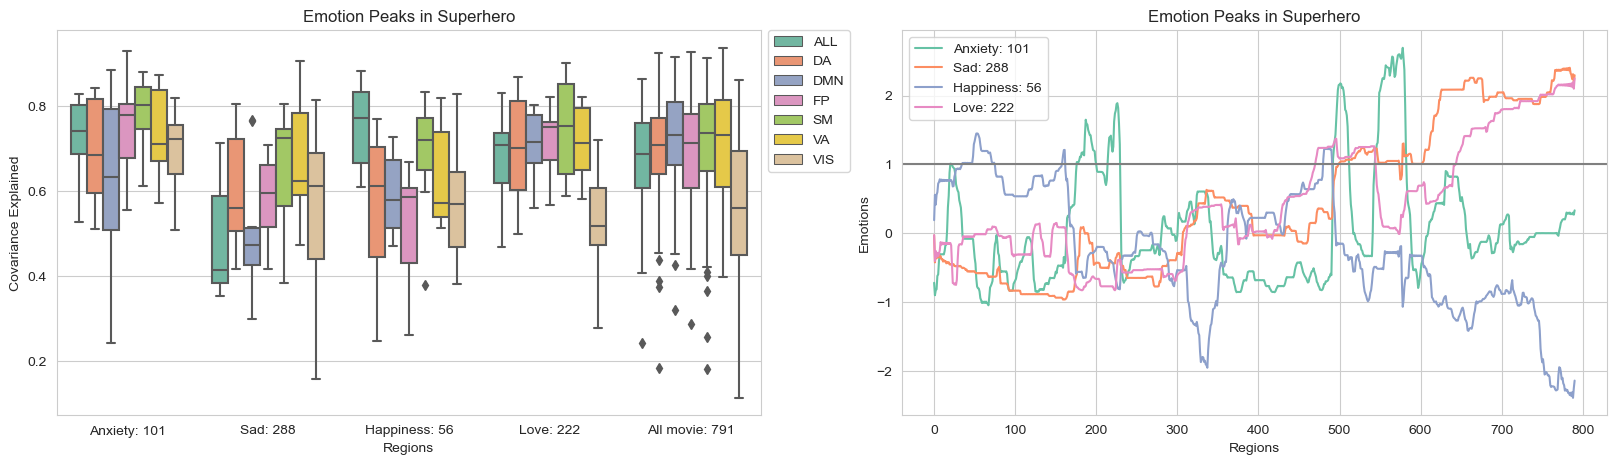

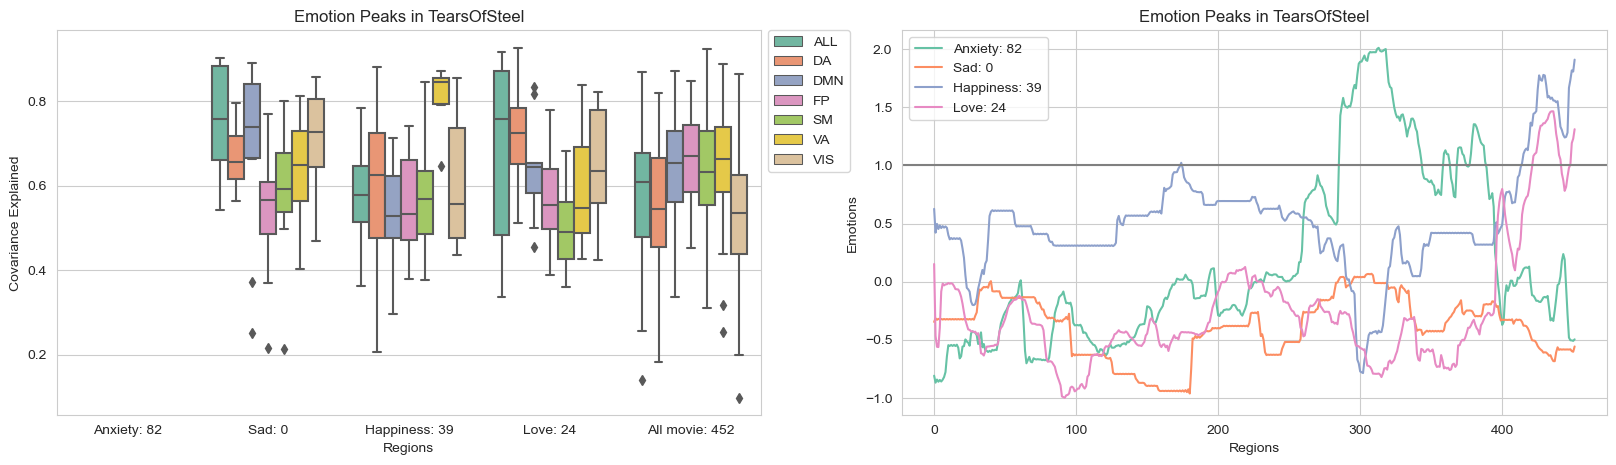

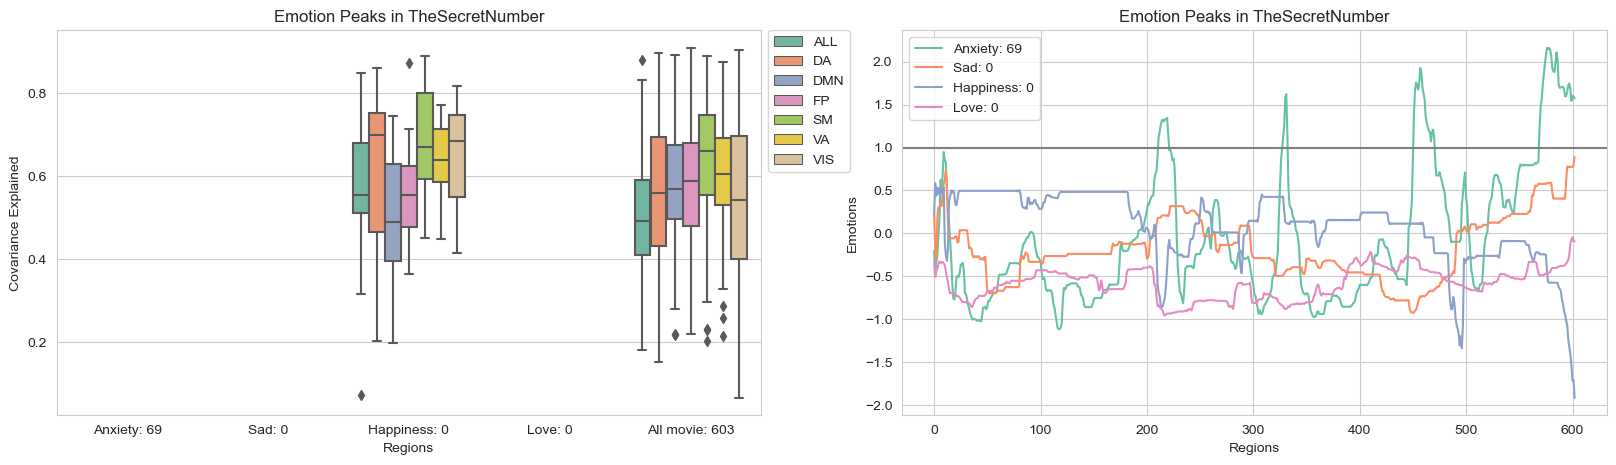

In [340]:
import seaborn as sns

for movie in ['Sintel', 'Superhero', 'TearsOfSteel', 'TheSecretNumber']:

    # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
    data_emo = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks.csv')
    data_emo.drop(['Unnamed: 0'], axis = 1, inplace = True)
    significant = data_emo[data_emo['P-value'] < 0.05]
    significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'emotion']).sum()['Covariance Explained'].reset_index()

    # read the all movie data columns:      Movie Region bootstrap_round emotion Covariance Explained # where the emotion column is all nan
    data_all_movie = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_all_fn_bootstrap_results.csv')
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'emotion']).sum()['Covariance Explained'].reset_index()

    # merge the two dataframes
    significant = pd.concat([significant, significant_all_movie], axis = 0)
    significant = significant[significant['Movie'] == movie]

    # add the number of points to the dataframe
    for emotion in emotions:
        significant.loc[significant['emotion'] == emotion, 'Number of points'] = count_pts[movie][emotion]
    significant.loc[significant['emotion'] == 'All movie', 'Number of points'] = count_pts[movie]['All movie']

    # EMOTION PEAKS
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']
    emotions = data_emo.emotion.unique()

    # PLOT
    palette = sns.color_palette("Set2")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    # plot the boxplot
    sns.boxplot(x = 'emotion', y = 'Covariance Explained', hue = "Region", order = ['Sad', 'Happiness', 'Anxiety', 'Love', 'All movie'], data = significant, ax = ax1, palette = palette)
    list_n = []
    for emo in ['Anxiety', 'Sad', 'Happiness', 'Love', 'All movie']:
        n = significant[significant['emotion'] == emo]['Number of points'].unique()
        if len(n) == 0:
            n = 0
        else:
            n = n[0]
        list_n.append(f'{emo}: {int(n)}')
    ax1.set_xticklabels(list_n)
    ax1.set_title(f'Emotion Peaks in {movie}')
    ax1.set_xlabel('Regions')
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

    list_emot = ['Sad', 'Happiness', 'Anxiety', 'Love', 'All movie']
    for emotion in list_emot:
        
        ax1.annotate(f'n = {int(n)}', xy=(list(list_emot).index(emotion), -0.25), xytext=(list(list_emot).index(emotion), 0.05), fontsize = 12)

    # plot the lineplot
    for i, emotion in enumerate(emotions):
        plt.plot(data[emotion], label = list_n[i], color = palette[list(emotions).index(emotion)])

    ax2.set_title(f'Emotion Peaks in {movie}')
    ax2.set_xlabel('Regions')
    ax2.set_ylabel('Emotions')
    ax2.axhline(y=1, color='grey', linestyle='-')
    ax2.legend()
    

    plt.show()

In [246]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

df_bootstrap = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
list_functionalnetworks = ['ALL', 'DA', 'DMN', 'FP', 'SM', 'VA', 'VIS']

method = 'bold'

df_all_fn = pd.DataFrame()
for fn in list_functionalnetworks:
    PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_{fn}_bootstrap_results.csv'
    df = pd.read_csv(PATH, index_col=0).reset_index()
    df['Region'] = fn

    n_movies = df.Movie.unique()
    a = np.repeat(np.arange(1,101), 12)
    for i in range(n_movies.shape[0]-1):
        a = np.concatenate((a, np.repeat(np.arange(1,101), 12)), axis = 0)
    df['bootstrap_round'] = a
    df['emotion'] = 'All movie'
    
    df_all_fn = pd.concat([df_all_fn, df], ignore_index=True)

df_all_fn.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_all_fn_bootstrap_results.csv')

In [315]:
list(significant.emotion.unique())

['Anxiety', 'Happiness', 'Sad', 'All movie', 'Love']